# Introduction
In order to accurately predict the stock price for a given ticker symbol, the model that is used needs to be tuned for said ticker. A ticker in this is the symbol under which a company can be found on the stock exchange. For example, Apple has the ticker symbol AAPL.

The model will predict 180 days into the future and will attempt to accurately give an estimated value for the adjusted close for a ticker symbol. For the actual model training the [facebook prophet](https://pypi.org/project/fbprophet/) library was used.

## Gridsearch for Prophet parameters
Prophet has a wide range of parameters to tune. Starting from the number of significant dates (changepoints) you want to include, how heavy these change points should influence the future data, all the way through to adding you own defined seasonal trends.

For this project the following three parameters where picked to optimize:
1. Change point prior scale; How heavy should the trends identified by these change points weigh
2. Change point range; How much of the historical data should be used to identify change points
3. Seasonality prior scale; How heavy is the seasonal component of the model

These three were picked after manually investigating a subset of ticker symbols. Some of them showed a seasonal trend which others show heavy changes on certain dates/after certain events. These parameters seem to be a good fit for our naive initial approach.

ParameterGrid() from the sklearn pacakge was used to define the following grid:
```python
prophet_param_grid = ParameterGrid({'changepoint_prior_scale':[i/100 for i in range(5,55,10)],
                  'yearly_seasonality':['auto'],
                  'seasonality_prior_scale':[2,5,10,20],
                  'changepoint_range': [0.8, 0.9, 1.0]
                 })
```
*yearly_seasonality here using the default value and depends on if a dataset had enough historical data.


## Ticker symbols
The below list of ticker symbols where included for the initial investigation. The list was manually picked to include the big 3 out of the 4 big tech companies to see if there stock behaves in similar fashion. Other companies where picked out of interest and from different industries to introduce some diversity.
- AAPL
- GOOG
- MSFT
- ADYEN.AS
- AMZN
- AGN.AS `Dropped`
- AKZA.AS `Dropped`
- ASML
- GLPG `Dropped`


## Gridsearch output & evaluation
Prophet was used to determine the 180 days of forecast into the future. For the error a Mean Abosolute Percentage Error (MAPE) was used to evaluate performance. The results for the gridsearch were stored in a CSV file and are **exposed below in a series of heatmaps**.

The evaluation below is visualised as heatmaps to make it easier to spot correlations. After the initial performace evaluation `AGN.AS`, `GLPG` and `AKZA.AS` where dropped from the supported ticker list. The current set of parameters clearly did not work for these companies.

Overall the other companies show benefit with a `change_point_prior_scale` value of around 0.15, indicating that the prior scale has some influence but is not the most important driver for the actual rate. Furthermore, using 80 to 90% of the data for changepoint prediction seems to increase accuracy for the companies as well.

Lastly, the `seasonality_prior_score` seems to favor a lower weight (2) than the default value (10), this indicates that the ticker symbols included in this analysis showed a low impact from the yearly and monthly seasonality effects.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Index naming logic: "changepoint_prior_scale"_"changepoint_range"_"seasonality_prior_scale"

grid_search_df = pd.read_csv('grid_search_prophet_tickers.csv', sep='\t', index_col=0)

## Split index name into multiindex for easy sorting
multi_index = pd.MultiIndex.from_arrays(
    list(zip(*grid_search_df.index.str.split('_'))),
    names=['changepoint_prior_scale','changepoint_range','seasonality_prior_scale']
)
grid_search_df.index = multi_index

grid_search_df.head()

AAPL  \
changepoint_prior_scale changepoint_range seasonality_prior_scale             
0.05                    0.8               2                        0.105244   
                                          5                        0.103633   
                                          10                       0.109231   
                                          20                       0.106391   
                        0.9               2                        0.159346   

                                                                       GOOG  \
changepoint_prior_scale changepoint_range seasonality_prior_scale             
0.05                    0.8               2                        0.087509   
                                          5                        0.084256   
                                          10                       0.089692   
                                          20                       0.094344   
                        0.9               2                        0.050062   

                                                                       MSFT  \
changepoint_prior_scale changepoint_range seasonality_prior_scale             
0.05                    0.8               2                        0.030520   
                                          5                        0.029421   
                                          10                       0.029530   
                                          20                       0.030632   
                        0.9               2                        0.025865   

                                                                   ADYEN.AS  \
changepoint_prior_scale changepoint_range seasonality_prior_scale             
0.05                    0.8               2                        0.095152   
                                          5                        0.093943   
                                          10                       0.092362   
                                          20                       0.094600   
                        0.9               2                        0.088551   

                                                                       AMZN  \
changepoint_prior_scale changepoint_range seasonality_prior_scale             
0.05                    0.8               2                        0.084762   
                                          5                        0.087816   
                                          10                       0.087031   
                                          20                       0.084919   
                        0.9               2                        0.093601   

                                                                     AGN.AS  \
changepoint_prior_scale changepoint_range seasonality_prior_scale             
0.05                    0.8               2                        0.105885   
                                          5                        0.104028   
                                          10                       0.103947   
                                          20                       0.104498   
                        0.9               2                        0.147027   

                                                                    AKZA.AS  \
changepoint_prior_scale changepoint_range seasonality_prior_scale             
0.05                    0.8               2                        0.224474   
                                          5                        0.189209   
                                          10                       0.205965   
                                          20                       0.232113   
                        0.9               2                        0.233407   

                                                                       ASML  \
changepoint_prior_scale changepoint_range seasonality_prior_scale             
0.05                    0.8        

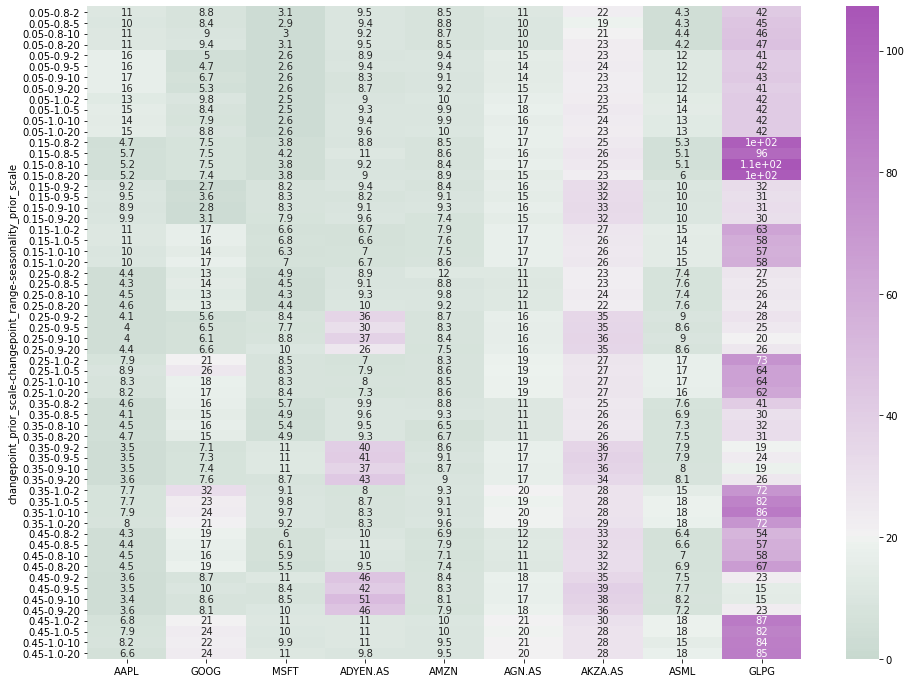

In [6]:
## Plot heatmap to get an idea of performance
fig, ax = plt.subplots(figsize=(16,12)) # Sample figsize in inches

sns.heatmap(grid_search_df*100,
            annot=True,
            ax=ax,
            vmin=0,
            vmax=grid_search_df.max().max()*100,
            center=20,
            cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)
           );

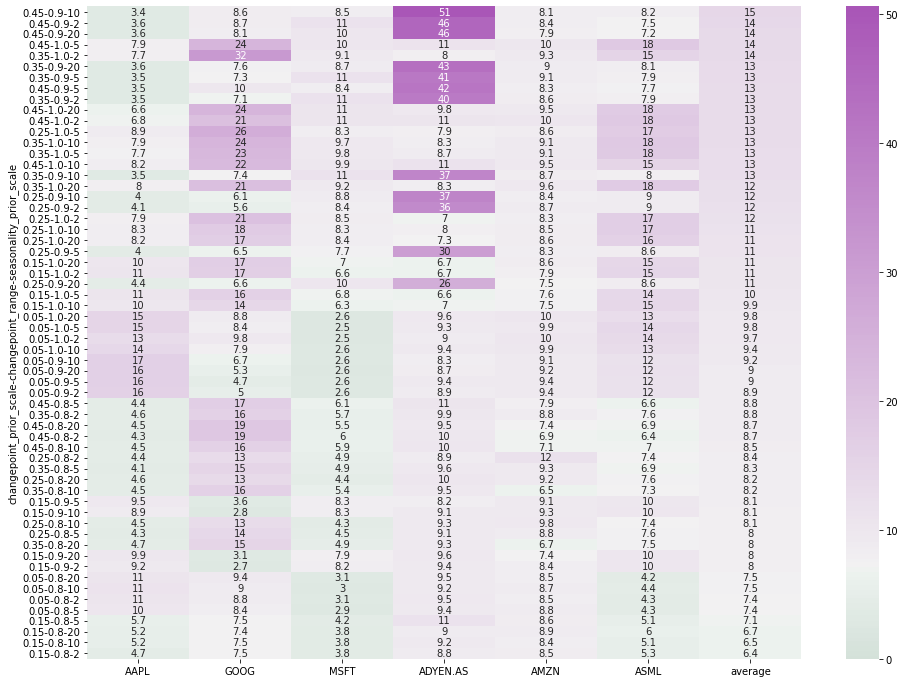

In [9]:
## Drop GLPG, AKZA.AS and AGN.AS due to poor performance

grid_mf_s = grid_search_df.drop(['AKZA.AS','GLPG','AGN.AS'], axis=1)

## Add mean to sort on overall performance
grid_mf_s['average'] = grid_mf_s.mean(axis=1)


## Plot the sorted 
fig, ax = plt.subplots(figsize=(16,12)) # Sample figsize in inches

sns.heatmap(grid_mf_s.sort_values(by='average', ascending=False)*100,
            annot=True,
            ax=ax,
            vmin=0,
            vmax=grid_mf_s.max().max()*100,
            center=7,
            cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)
           );